# Imports

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# Configs

In [2]:
INPUT_PATH = 'datasets/'

OUTPUT_PATH_TEST = 'results/ridge_test_predictions.parquet'
OUTPUT_PATH_TRAIN = 'results/ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [
                'Previous_week_max_demand',
                'Previous_2week_max_demand',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',
                
                #'Day_of_week',
                #'Day_of_month'
                ]

TEST_START_DATE = '2023-04-01'
VALIDATION_START_DATE = '2023-03-21'

GROUP_NUM = 3

# Data preparation


## Load Data

In [3]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [5]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


## Labeling

In [6]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df

In [7]:
labeled_df = labeling(rides_df)

In [8]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head(10)

labeled dataframe shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0
5,1,2023-01-06,11.0
6,1,2023-01-07,6.0
7,1,2023-01-08,12.0
8,1,2023-01-09,14.0
9,1,2023-01-10,4.0


## Add Feature

In [9]:
def feature_engineering(dataset):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['Location'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['Location'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['Location'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['Location'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['Location'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['Location'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)

    dataset['Previous_week_max_demand'] = dataset.groupby('Location')['Demand'].rolling(window=7).max().reset_index(drop = True)
    dataset['Previous_2week_max_demand'] = dataset.groupby('Location')['Demand'].rolling(window=14).max().reset_index(drop = True)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek + 1
    dataset['Day_of_month'] = dataset['Date'].dt.day
    
    return dataset

In [10]:
features_df = feature_engineering(labeled_df)
features_df.dropna(inplace = True)

In [11]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 21)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
14,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,...,11.0,15.0,7.0,27.0,31.0,40.0,21.0,31.0,7,15
15,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,...,6.0,11.0,15.0,7.0,27.0,31.0,21.0,27.0,1,16
16,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,...,12.0,6.0,11.0,15.0,7.0,27.0,21.0,21.0,2,17
17,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,...,14.0,12.0,6.0,11.0,15.0,7.0,21.0,21.0,3,18
18,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,...,4.0,14.0,12.0,6.0,11.0,15.0,21.0,21.0,4,19


## Split Train and Test Data

In [12]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [13]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [14]:
grid_search_train_df, valid_df = train_test_splitting(train_df, VALIDATION_START_DATE) 

In [15]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 21)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
14,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,...,11.0,15.0,7.0,27.0,31.0,40.0,21.0,31.0,7,15
15,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,...,6.0,11.0,15.0,7.0,27.0,31.0,21.0,27.0,1,16
16,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,...,12.0,6.0,11.0,15.0,7.0,27.0,21.0,21.0,2,17
17,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,...,14.0,12.0,6.0,11.0,15.0,7.0,21.0,21.0,3,18
18,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,...,4.0,14.0,12.0,6.0,11.0,15.0,21.0,21.0,4,19


In [16]:
print(f'validation dataframe shape : {valid_df.shape}')
valid_df.head()

validation dataframe shape : (2882, 21)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
79,1,2023-03-21,6.0,14.0,33.0,25.0,18.0,12.0,5.0,14.0,...,20.0,14.0,15.0,19.0,20.0,15.0,33.0,33.0,2,21
80,1,2023-03-22,9.0,6.0,14.0,33.0,25.0,18.0,12.0,5.0,...,13.0,20.0,14.0,15.0,19.0,20.0,33.0,33.0,3,22
81,1,2023-03-23,21.0,9.0,6.0,14.0,33.0,25.0,18.0,12.0,...,14.0,13.0,20.0,14.0,15.0,19.0,33.0,33.0,4,23
82,1,2023-03-24,9.0,21.0,9.0,6.0,14.0,33.0,25.0,18.0,...,5.0,14.0,13.0,20.0,14.0,15.0,33.0,33.0,5,24
83,1,2023-03-25,15.0,9.0,21.0,9.0,6.0,14.0,33.0,25.0,...,12.0,5.0,14.0,13.0,20.0,14.0,33.0,33.0,6,25


In [17]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 21)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,...,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Day_of_week,Day_of_month
90,1,2023-04-01,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,...,21.0,9.0,6.0,14.0,33.0,25.0,14.0,33.0,6,1
91,1,2023-04-02,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,...,9.0,21.0,9.0,6.0,14.0,33.0,17.0,21.0,7,2
92,1,2023-04-03,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,...,15.0,9.0,21.0,9.0,6.0,14.0,17.0,21.0,1,3
93,1,2023-04-04,12.0,9.0,17.0,13.0,13.0,13.0,7.0,14.0,...,14.0,15.0,9.0,21.0,9.0,6.0,17.0,21.0,2,4
94,1,2023-04-05,18.0,12.0,9.0,17.0,13.0,13.0,13.0,7.0,...,3.0,14.0,15.0,9.0,21.0,9.0,18.0,21.0,3,5


# Model Training

### **Ridge Regression**

#### Model Tuning

In [33]:
def grid_search(model_class, param_grid, train_df, val_df, feature_list):
    best_params = None
    best_val_loss = float('inf')

    for params in product(*param_grid.values()):
        current_params = dict(zip(param_grid.keys(), params))
        current_model = model_class(**current_params)
        # model = Pipeline([
        #     ('scaler', StandardScaler()),
        #     ('model', current_model)
        # ])
        current_model.fit(train_df[feature_list], train_df['Demand'])
        
        y_val_pred = current_model.predict(val_df[feature_list])
        val_loss = mean_squared_error(val_df['Demand'], y_val_pred)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = current_params
    
    return best_params, best_val_loss

In [34]:
model = Ridge
best_params, best_score = grid_search(
    model, 
    {'alpha':[1, 10, 100],
     },
    grid_search_train_df,
    valid_df, 
    feature_list = FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 1} 7605.460180511987


#### Prediction

In [35]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])

    train_predict_df = model.predict(train_data[feature_list])
    test_predict_df = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [36]:
model = Ridge(**best_params)
# model = Pipeline([
#             ('scaler', StandardScaler()),
#             ('model', base_model)
#         ])

train_prediction_df , test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

#### Visualization

In [37]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
    test_data['Day_of_year'] = test_data['Date'].dt.dayofyear

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('Day_of_year')['Demand'].sum()
    test_data = test_data.groupby('Day_of_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('Day_of_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('Day_of_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\bardia\AppData\Local\Temp\ipykernel_12868\242743045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Day_of_year'] = train_data['Date'].dt.dayofyear
C:\Users\bardia\AppData\Local\Temp\ipykernel_12868\242743045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Day_of_year'] = test_data['Date'].dt.dayofyear
C:\Users\bardia\AppData\Local\Temp\ipykernel_12868\242743045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

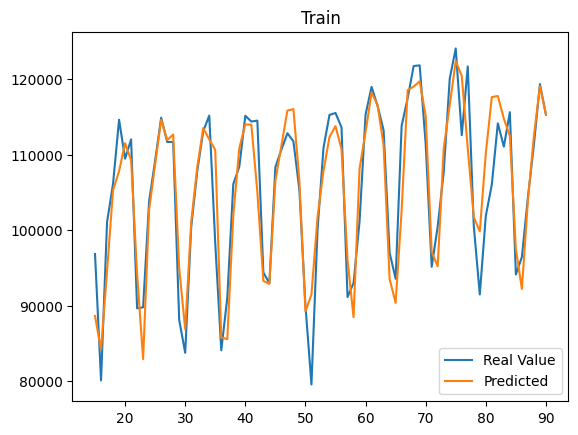

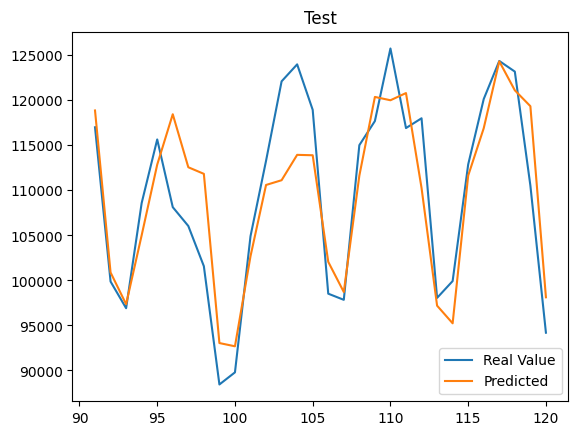

In [38]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

#### Evaluation

In [39]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [40]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')

    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'\n{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [41]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 28.805178104938282
MSE : 8461.67359690179
MAPE : 714631502028172.0

Ridge Regression test scores:
MAE : 29.4396862118538
MSE : 7778.729516420975
MAPE : 712042651381408.5


# File Saving

In [42]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [43]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [44]:
labeled_test_prediction_df = prediction_labeling(test_prediction_df, test_df)
labeled_train_prediction_df = prediction_labeling(train_prediction_df, train_df)

C:\Users\bardia\AppData\Local\Temp\ipykernel_12868\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df
C:\Users\bardia\AppData\Local\Temp\ipykernel_12868\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [45]:
print(f'labeled prediction dataframe shape : {labeled_test_prediction_df.shape}')
labeled_test_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,16.058503
1,1,2023-04-02,19.940854
2,1,2023-04-03,10.172899
3,1,2023-04-04,10.371798
4,1,2023-04-05,9.977403


In [46]:
print(f'labeled prediction dataframe shape : {labeled_train_prediction_df.shape}')
labeled_train_prediction_df.head()

labeled prediction dataframe shape : (19912, 3)


,Location,Date,Predicted_demand
0,1,2023-01-15,20.237013
1,1,2023-01-16,23.753488
2,1,2023-01-17,16.325936
3,1,2023-01-18,13.698380
4,1,2023-01-19,13.702708


In [47]:
save_predictions(labeled_train_prediction_df, OUTPUT_PATH_TRAIN)
save_predictions(labeled_test_prediction_df, OUTPUT_PATH_TEST)